# STAT5243 Project 4: Causal Inference Algorithms Evaluation

***Group 2:***

    Wendy Doan (ad3801)
    Yibai Liu (yl4616)
    Shuqi Yu (sy2950)
    Yiwen Fang (yf2560)
    Zhihang Xia (zx2338)

***Instruction for using this notebook:*** *You can click `Restart & Run All` to reproduce the full evaluation results. Outputs in each step are only as illustrations of our development workflow.*

## Introduction

In this project, we studied **Causal Inference** on two datasets, one high-dimensional and another low-dimensional. 

Specifically, we estimated the **Average Treatment Effects (ATE)** by calculating the **Propensity Scores (PS)** using the **Boosting Stumps** algorithms. 

The ATEs are then calculated using three models and compared with the true values to estimate accuracy. For each algorithm and method,  The performance and computational efficiency were evaluated for each dataset to select the best combination. 

#### Propensity Score Estimation Methods: (Boosting Stumps)
1. GBM 
2. XGboost

We define the *propensity score* in terms of probability as:   $ e(x) = Pr(T =1|X=x)$, where $ 0<e(x)<1 $

#### ATE Estimation Methods:
1. Stratification
2. Regression Adjustment
3. Stratification + Regression Adjustment 

To aid with propensity score prediction, we also attempted to alleviate the slight imbalance in the data through well known methods such as random oversampling and SMOTE.

##  Step 0: Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(42)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

## Step 1: Import and explore data

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

We have two dataset, `High Dimensional Dataset` and `Low Dimensional Dataset`

In [2]:
# Set up your directory for the datasets
directory = "../"

In [3]:
highDim_dataset = pd.read_csv(directory + 'data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv(directory + 'data/lowDim_dataset.csv')

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [4]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

In [5]:
#========================================================================
# Choose a development option between highDim_dataset and lowDim_dataset
#========================================================================

dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

#dataset = highDim_dataset.copy()
#dataset_name = "High-Dimensional Dataset"
#true_ATE = high_true_ATE

In [6]:
dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


The high-dimensional dataset has 2000 observations of 187 dimensions, while the low-dimensional dataset has 500 observations of 24 dimensions.

It is convenient to extract only the X portion, which is columns other than Y (treatment result) and A (binary treatment/control group)

In [7]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [8]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,0.00,0.00,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,0.42,0.05,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [9]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title(dataset_name + " Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

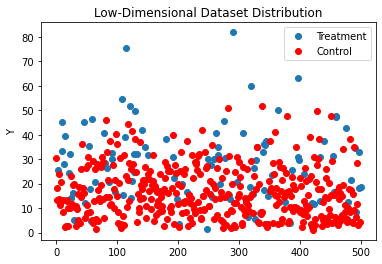

In [10]:
plotComposition(dataset)

### Are the data sets balanced?

In [11]:
def checkComposition(dataset):
    print("The dataset contains:\n",len(dataset[dataset.A == 1]), "cases in Treatment group\n", 
          len(dataset[dataset.A == 0]), "cases in Control group.")
    print("Treatment/Control ratio: {}/100".format(round(len(dataset[dataset.A == 1])/len(dataset[dataset.A == 0])*100)))

In [12]:
print("High-dimensional")
checkComposition(highDim_dataset)
print('-'*20)
print("Low-dimensional")
checkComposition(lowDim_dataset)

High-dimensional
The dataset contains:
 643 cases in Treatment group
 1357 cases in Control group.
Treatment/Control ratio: 47/100
--------------------
Low-dimensional
The dataset contains:
 106 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 27/100


In this case, the high-dimensional data is slightly imbalanced, but acceptable. However, the low-dimensional data displays severer imbalance between groups. In any cases, one can use resampling to balance the data, however it may not be beneficial for some ATE estimation algorithms. 

## Step 2: Naive estimate of ATE

Check the origianl ATE for both high and low dimension data without any steps and algorithms

In [13]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [14]:
print("Naive ATE for high-dimensional data:", naive_ATE(highDim_dataset))
print("Naive ATE for low-dimensional data:", naive_ATE(lowDim_dataset))

Naive ATE for high-dimensional data: -75.17133436876799
Naive ATE for low-dimensional data: 10.602068661915688


## Step 3: Data preprocessing


### Oversampling to deal with the imbalanced data

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. We used oversampling the minority instead of undersampling the majority since undersampling removes instances from data that may be carrying important information.


1. **Random Oversampling**: 

To randomly replicate the small sample to match the size of the larger sample.

2. **SMOTE**: Synthetic Minority Oversampling Technique

SMOTE generates synthetic samples from the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.



In [15]:
def Oversample(dataset):
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x, y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 394 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 100/100


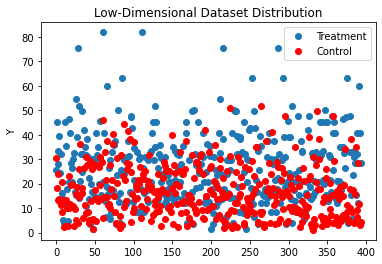

In [16]:
dataset_oversampled = Oversample(dataset)

checkComposition(dataset_oversampled)
plotComposition(dataset_oversampled, reset_index=True)

In [17]:
def SMOTE(dataset):
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 384 cases in Treatment group
 384 cases in Control group.
Treatment/Control ratio: 100/100


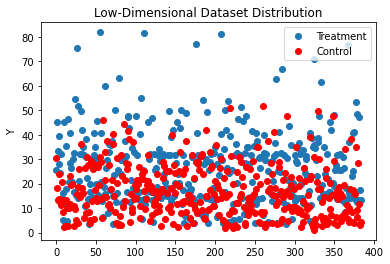

In [18]:
dataset_smote = SMOTE(dataset)

checkComposition(dataset_smote)
plotComposition(dataset_smote, reset_index=True)

In summary, there are three dataset that can be used: orginial, oversampled, and SMOTE. For testing purpose, change the variable splitted in the beginning of the next section, instead of pasting them all into one notebook. 

## Step 4: Calculating the propensity scores

The propensity score is estimated by applying machine learning methods on the `X` variable to fit the label `A`. For this purpose (and this purpose only) the dataset is splitted into train and test set. 

### 4.1 Split into train and test sets

We split the dataset into train and test with the porpotion of 20:80. We will use the train data to train the model and do the cross validation to avoid overfitting. Then use the test data to check our model

In [19]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, 
                                                test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

Update dataset name HERE to test the original, oversampled, SMOTE, or any new dataset. 

In [20]:
#=============================================================================
# Development choices include dataset, dataset_oversampled and dataset_smote
#=============================================================================

X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(dataset)

### 4.2 Propensity Score - Boosted Stumps

In this notebook we use GBM and XGboost. For any choices of learner, it is desirable to perform cross validation and grid search for the best model. We then evaluate the model prediction on the test set. 

#### Gradient Boosting

In [21]:
param_grid = {
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 4],
              'n_estimators': [5, 10, 15, 20],
              'min_samples_leaf':[1, 3, 5]
              }

In [22]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step=True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A, 
                                                                sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [23]:
# gbm = grid_search(
#     X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), 
#     param_grid=param_grid,
#     print_step=True)

A copy of best hyperparameters from grid search

In [24]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 
               'min_samples_split': 4, 'n_estimators': 20}

gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train)

In [25]:
print(gbm.score(X_train, A_train))
print(gbm.score(X_test, A_test))

0.8975
0.81


In [26]:
# Predict propensity scores
propensity_score_gbm = np.exp(gbm.predict_log_proba(dataset.iloc[:, 2:]))[:, 1]

#### XGBoost

In [27]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[5, 10, 15, 20],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [28]:
# xgb = grid_search(X_train, A_train, 
#             model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE),
#             param_grid = param_grid_xgb, 
#             print_step=True, 
#             cv=5
#            )           

A copy of best hyperparameters from grid search

In [29]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [30]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.8775
0.8


In [31]:
# Predict propensity scores
propensity_score_xgb = xgb.predict_proba(np.array(dataset.iloc[:, 2:]))[:, 1]

To summarize, we have obtained the propensity scores using GBM and XGBoost. These can now be used to calculate the ATE score. 

## Step 5: Extract relevant data for ATE calculation

It is convenient to attach the newly constructed propensity score with `A` and `Y`. For the stratification, this is all required. However for regression method, `X` is also required to remove further confounding factors. 

In [32]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

**We summarized the selected models in the following pipeline:**

In [33]:
def data_preparation_pipeline(dataset:pd.DataFrame, resample=None, label=dataset_name, boost='GBM'):
    """
    Each sampling method results in a different data size, a set of best 
    hyperparameters from grid search, and an array of sample weights. 
    This pipeline prepares a dataset, with the specified resampling method, 
    for the later ATE estimation.
    
    inputs
    -------
    dataset: pd.DataFrame, the dataset used to evaluate algorithms
    resample: str or None, used when resampling methods are applied. Possible values are None, 'over', or 'smote'
    label: str, name of the dataset
    boost: str, the boosting method used to predict propensity scores. Possible values are 'GBM', 'XGB'
    
    outputs
    -------
    ps_data: pd.DataFrame, contains three columns for propensity scores, group, and outcome variable
    X_data: pd.DataFrame, contains X variables
    """
    test_scores = []
    params = []
    weights =[]

    if resample == None:
        data = dataset
    elif resample == 'over':
        data = Oversample(dataset)
    elif resample == 'smote':
        data = SMOTE(dataset)
    else:
        print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
    
    X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(data)
    
    # ================================== Predict PS with GBM ===================================
    if boost=='GBM':    
        # A copy of the best hyperparameter candidates from grid search:
        if label == 'Low-Dimensional Dataset':
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 
                            'min_samples_split': 2,'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 
                           'min_samples_split': 4,'n_estimators': 100}
        elif label == "High-Dimensional Dataset":
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 
                            'min_samples_split': 2, 'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 
                           'min_samples_split': 4, 'n_estimators': 100}
        else:
            print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
            
        params_list = [gbm_params1, gbm_params2]
        
        for i in range(15,22):
            # high-dimensional weights (the best weights after multiple trials)
            sample_weights = np.zeros(len(A_train))
            sample_weights[A_train == 0] = i
            sample_weights[A_train == 1] = 20
            
            for p in params_list:
                gbm = GradientBoostingClassifier().set_params(**p).fit(X_train, A_train,sample_weight=sample_weights)
                #print(gbm.score(X_train, A_train), gbm.score(X_test, A_test))
                test_scores.append(gbm.score(X_test, A_test))
                params.append(p)
                weights.append(sample_weights)
            
        best_ = params[test_scores.index(max(test_scores))]
        #print("GBM parameters:", best_)
        gbm = GradientBoostingClassifier().set_params(**best_).fit(X_train, A_train,
                                  sample_weight=weights[test_scores.index(max(test_scores))])
        #print("GBM train accuracy: ",gbm.score(X_train, A_train))
        #print("GBM test accuracy: ", gbm.score(X_test, A_test))
        propensity_score_gbm = np.exp(gbm.predict_log_proba(data.iloc[:, 2:]))[:, 1]
    
        ps_data = combine_data(propensity_score_gbm, data.A, data.Y)
    
    # ================================== Predict PS with XGB ==================================
    elif boost=='XGB':
        best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

        xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)
        #print("XGboost train accuracy: ",xgb.score(X_train, A_train))
        #print("XGboost test accuracy: ", xgb.score(X_test, A_test))
        propensity_score_xgb = xgb.predict_proba(np.array(data.iloc[:, 2:]))[:, 1]
        ps_data = combine_data(propensity_score_xgb, data.A, data.Y)
        
    else:
        print("Error: Wrong boosting methods! Possible options include 'GBM' and 'XGB'")
        
    X_data = data.drop(['Y', 'A'], axis=1)
    return ps_data, X_data


## Step 6: Calculating ATE with different algorithms

### 6.1 ATE Estimate - Stratification

A common approach to estimate ATE using stratification based on propensity scores. The procedure is as follow: : (i) Estimate propensity scores $e_i$ accross all samples; (ii) form $K$ strata according to the sample quantiles of the $e_i$, such that the treated and control have roughly the same proportion within each strata; (iii) within each stratum, calculate the difference of sample means of the $Y_i$ for each treatment; and (iv) estimate $\Delta$ by a weighted sum of the differences of sample means across strata, where weighting is by the proportion of observations falling in each stratum

$$ 
\hat{∆}_S = \sum_{j=1}^{k}(N_j / N)\{N^{−1}_{1j} \sum_{i=1}^{N} T_i*Y_i*I(e_i ∈ Q_j ) − N^{−1}_{0j}*\sum^{N}_{i=1}(1 − T_i)Y_i*I(e_i ∈ Q_j ) 
$$

where K is the number of strata, some literature have advocate to use quintiles (K=5). 
$N_{j}$ is the number of individuals in stratum j. $N_{1j}$ is the number of “treated” individuals in stratum `j`, while $N_{0j}$ is the number of “controlled” individuals in stratum `j`. $$Q_j = (q_{j−1}, q_{j}] $$ where $q_j$ is the jth sample quantile of the estimated
propensity scores. (See Lunceford and Davidian (2004))

In [34]:
def Stratify(ps_data:pd.DataFrame, k:int):
    
    data_copy = ps_data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [35]:
def Calculate_ATE_Strat(ps_data:pd.DataFrame, k:int):
    
    n = ps_data.shape[0]
    
    data_copy = Stratify(ps_data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        treat_avg = np.average(Qj[Qj.A==1].Y) if Qj[Qj.A==1].shape[0] != 0 else 0
        control_avg = np.average(Qj[Qj.A==0].Y) if Qj[Qj.A==0].shape[0] != 0 else 0
        ATE += (nj/n) * ( treat_avg - control_avg )
    
    return ATE

### 6.2 ATE Estimate - Regression Adjustment and Stratification + Regression Adjustment

Regression adjustment can be employed to reduce residual within-stratum confounding. With regression adjustment, data for each bin is further corrected using regression on `X`, with level variable `A`. 

Here, steps (iii) and (iv) above are modified as follows: (iii) within each stratum $j = 1,...,K,$ fit a regression model of the form $m^{(j)}(T, X, \alpha(j))$ representing the postulated regression relationship $E(Y |T, X)$ within stratum $j$ and, based on the result, estimate treatment effect in stratum $j$ by averaging over $X_i$ in $j$ as

$$ 
\hat{\Delta}^{(j)} = n^{-1}_{j} \sum_{i = 1}^{n} I(e_i ∈ Q_j ) (
m^{(j)}(1, X, \alpha^{(j)}) - m^{(j)}(0, X, \alpha^{(j)}) )
$$

and (iv) estimate $\Delta$ by the averaging

$$
\hat{\Delta}_{SR} = \frac{1}{K} \sum_{j=1}^{K} \Delta^{(j)}
$$

Note that a variation here is using two separate regression for $T$, which is not considered here.

Finally, setting k = 1 bin is equivalent to performing only regression estimation. 

In [36]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

## Step 7: Evaluating ATE estimation algorithms

### 7.1 Measuring the uncertainty of results

To estimate the accuracy, we used the squared error

$$
SE = (\hat{\Delta} - \Delta )^2
$$

Since the true error is often not known, one can alternatively estimate the uncertainty by random sampling the dataset. To give an example, here is an estimate for the $\hat{\Delta}_S$ using default GBM

In [37]:
def Calculate_ATE_Strat_CV(
    data_for_ATE:pd.DataFrame, k:int, frac=0.9, n=500
):
    ATEs = []
    m = data_for_ATE.shape[0]
    for i in range(n):
        temp = data_for_ATE.sample(frac=frac, replace=True)
        ATEs.append( Calculate_ATE_Strat(temp, k) )
        
    return ATEs

In [38]:
data_for_ATE = combine_data(propensity_score_gbm, dataset.A, dataset.Y)
ATEs = Calculate_ATE_Strat_CV(data_for_ATE, 5)
print("Mean: ", np.nanmean(ATEs), "\n" + "Stdev:", np.nanstd(ATEs))

Mean:  -2.2035991805034527 
Stdev: 1.4114584786952433


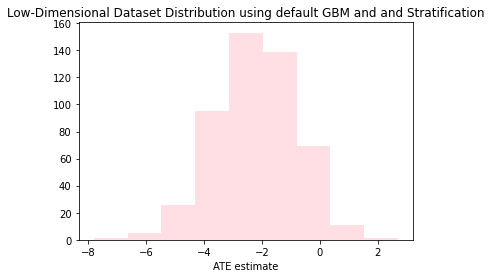

In [39]:
max_bins = 9
n, bins, patches = plt.hist(ATEs, max_bins, facecolor='pink', alpha=0.5)
plt.title(dataset_name + " Distribution using default GBM and and Stratification")
plt.xlabel("ATE estimate")
plt.show()

Thus, for high dimensional dataset, the result can be trusted with uncertainty at around $5 \%$, while for low dimensional dataset only give order of magnitude estimate. This may be due the to high dimensional dataset being larger. 

### 7.2 Investigating the effects of different numbers of bins for stratification

In [42]:
def detailed_summary(dataset:pd.DataFrame, max_k:int, true_ATE=true_ATE, title="high", resample=None, boost='GBM'):
    """
    This function reads in data and returns best ATE estimation generated from the 
    most appropriate k value for each algorithm. This function is 
    
    inputs
    -------
    dataset: pd.DataFrame, the dataset used to evaluate algorithms
    max_k: int, the maximum k value used to calculate ATE
    true_ATE: float, the true ATE score used to plot against estimations
    title: str, a string used to label high/low-dimensional datasets in the plot. Possible values are "high" or "low"
    resample: str or None, used when resampling methods are applied. Possible values are None, 'over', or 'smote'
    boost: str, the boosting method used to predict propensity scores. Possible values are 'GBM', 'XGB'
    
    outputs
    -------
    log: pd.DataFrame, chunk of summary table generated from running the experiment
    
    """
    data, data_X = data_preparation_pipeline(dataset, resample=resample, label=dataset_name, boost=boost)
    
    strat_results = [Calculate_ATE_Strat(data, i) for i in range(1, max_k+1)]
    strat_reg_results = [Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, i) for i in range(1, max_k+1)]
    
    error = [abs(strat_results[i] - true_ATE) for i in range(len(strat_results))]
    best_k_strat = error.index(min(error))+1

    error = [abs(strat_reg_results[i] - true_ATE) for i in range(len(strat_reg_results))]
    best_k_strat_reg = error.index(min(error))+1
    
    start = time.time()
    strat = Calculate_ATE_Strat(data, best_k_strat)
    t_strat = time.time()-start
    print("Time for calculating ATE with stratification: {}s".format(round(t_strat, 4)))
    
    start = time.time()
    regadj = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, 1)
    t_regadj = time.time()-start
    print("Time for calculating ATE with regression adjustment: {}s".format(round(t_regadj, 4)))
    
    start = time.time()
    combined = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, best_k_strat_reg)
    t_combined = time.time()-start
    print("Time for calculating ATE with stratification + regression adjustment: {}s".format(round(t_combined, 4)))
    
    print("Estimated ATE by stratification with k = {}: {}".format(best_k_strat, strat))
    print("Estimated ATE by regression adjustment: {}".format(regadj))
    print("Estimated ATE by stratification + regression adjustment with k = {}: {}".format(best_k_strat_reg, combined))
    
    # resamping label
    if resample == 'over':
        resample_str = '(oversampled)'
    elif resample == 'smote':
        resample_str = '(SMOTE)'
    else: resample_str = ''
    
    # Add results to summary
    summary_cols=["Model", "Data", "PS model", "Estimation time(s)","Squared error"]
    log = pd.DataFrame(columns=summary_cols)
    row1= pd.DataFrame([[str('Stratification (K={})'.format(best_k_strat+1)), str(title+'-dim'+resample_str), boost, 
                         t_strat, round((strat-true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row1)
    row2= pd.DataFrame([['Regression Adjustment', str(title+'-dim'+resample_str), boost, 
                         t_regadj, round((regadj - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row2)
    row3= pd.DataFrame([[str('Strat. + Reg. Adj. (K={})'.format(best_k_strat_reg+1)), str(title+'-dim'+resample_str), boost, 
                         t_combined, round((combined - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row3)
    
    
    # Plot: 
    plt.figure(figsize=(10,6))
    plt.plot(range(1,max_k+1), strat_results, marker='o',
                label = 'ATE estimate by stratification')
    plt.plot(range(1,max_k+1), strat_reg_results, marker='o',
                label = 'ATE estimate by strat + reg_adj')
    plt.scatter(1, regadj, s=150, label='ATE estimate by regression adjustment',alpha=1, marker='o',c='green')

    plt.hlines(true_ATE, 1, max_k, colors='red', linestyles='dashed', label='ATE true')
    #plt.hlines(naive_ATE(data), 1, 10, colors='grey', linestyles='dashed', label='ATE Naive')
    plt.title("The {}-dimensional dataset {}\nTrue vs. Estimated ATE (PS predicted by {})".format(title, resample_str,boost))
    plt.xlabel("Number of strata (k)")
    plt.ylabel("ATE")
    plt.legend()
    plt.show()
    
    return log

Time for calculating ATE with stratification: 0.0089s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.012s
Estimated ATE by stratification with k = 4: 2.275243121990381
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 3: 2.0685854818779466


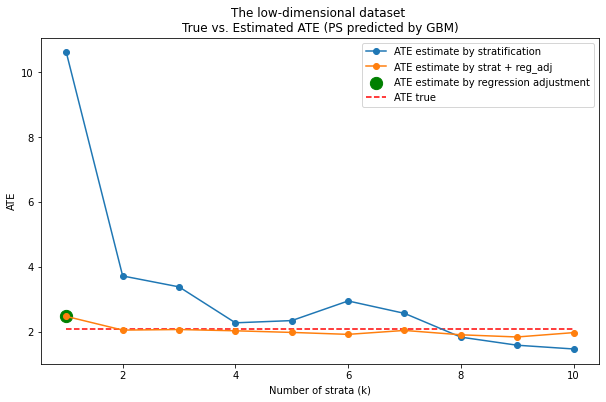

Time for calculating ATE with stratification: 0.009s
Time for calculating ATE with regression adjustment: 0.004s
Time for calculating ATE with stratification + regression adjustment: 0.006s
Estimated ATE by stratification with k = 3: 0.8137233699590745
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 2: 2.048101012119834


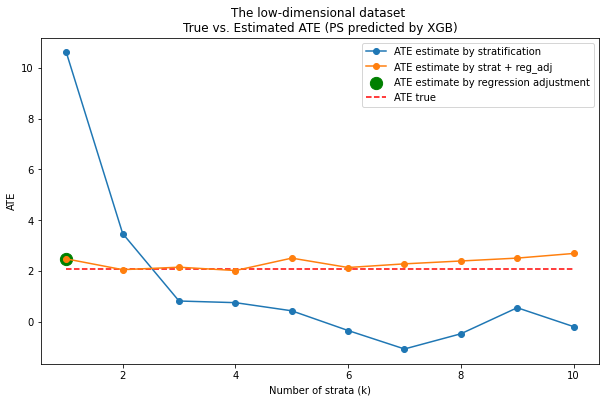

Time for calculating ATE with stratification: 0.013s
Time for calculating ATE with regression adjustment: 0.004s
Time for calculating ATE with stratification + regression adjustment: 0.009s
Estimated ATE by stratification with k = 6: 2.1227408863742427
Estimated ATE by regression adjustment: 2.1878718993061588
Estimated ATE by stratification + regression adjustment with k = 3: 2.123898789019409


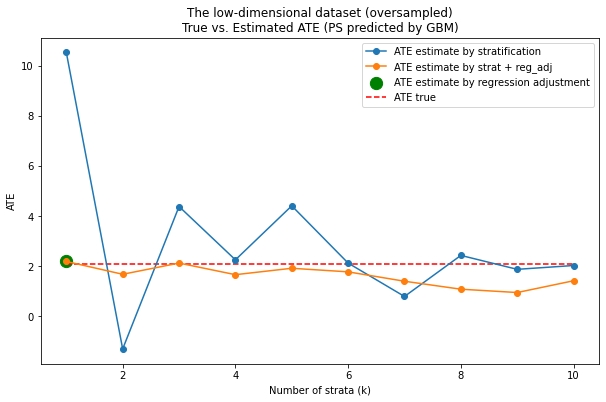

Time for calculating ATE with stratification: 0.02s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.007s
Estimated ATE by stratification with k = 9: 1.2514904189364446
Estimated ATE by regression adjustment: 2.209937764279153
Estimated ATE by stratification + regression adjustment with k = 2: 2.1134031438048693


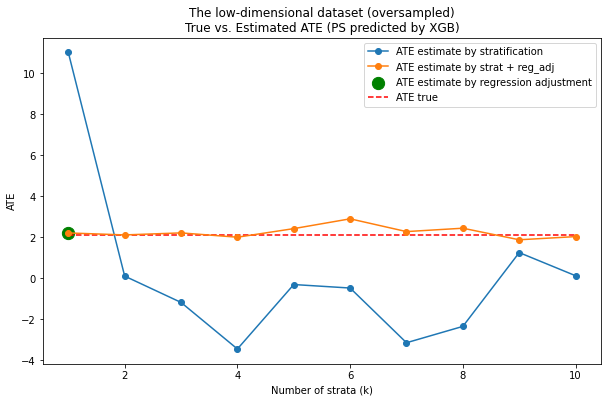

Time for calculating ATE with stratification: 0.013s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.007s
Estimated ATE by stratification with k = 7: 2.3816122055896414
Estimated ATE by regression adjustment: 2.416625281591553
Estimated ATE by stratification + regression adjustment with k = 2: 2.1046535420727404


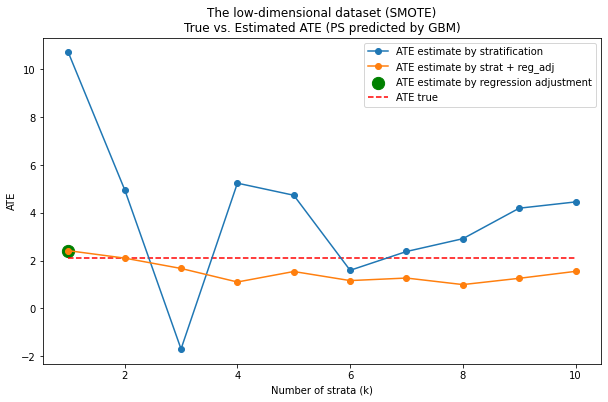

Time for calculating ATE with stratification: 0.005s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.025s
Estimated ATE by stratification with k = 2: 2.1534495482142892
Estimated ATE by regression adjustment: 2.4205426104457826
Estimated ATE by stratification + regression adjustment with k = 10: 2.2341187270718974


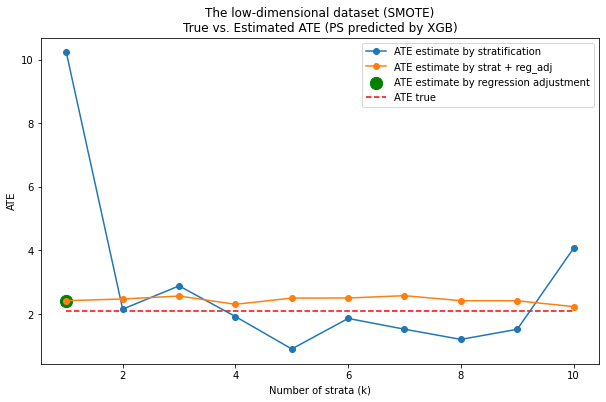

In [43]:
# To visualize the stability of stratification and strat + reg.adj. for different K values:
# Development choice: use the lowDim dataset
dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

#dataset = highDim_dataset.copy()
#dataset_name = "High-Dimensional Dataset"
#true_ATE = high_true_ATE

for r in [None,'over','smote']:
    for b in ['GBM','XGB']:
        log = detailed_summary(dataset, max_k=10, true_ATE=true_ATE, title="low", resample=r, boost=b)


**Note: When using the highDim_dataset, the ATE estimates would become far off for larger numbers of strata (K>8), so here consider reasonable K values in development with the highDim_dataset.**

### 7.3 Evaluation summary

In [44]:
summary_cols=["Model", "Data", "PS model", "Estimation time(s)","Squared error"]
summary = pd.DataFrame(columns=summary_cols)

In [45]:
def estimation_summary(dataset:pd.DataFrame, k:int, true_ATE=true_ATE, title="high", resample=None, boost='GBM'):
    """
    This function reads in data and returns best ATE estimation generated from each algorithm.
    
    inputs
    -------
    dataset: pd.DataFrame, the dataset used to evaluate algorithms
    k: int, the k value used in stratification to calculate ATE 
    true_ATE: float, the true ATE score used to plot against estimations
    title: str, a string used to label high/low-dimensional datasets in the plot. Possible values are "high" or "low"
    resample: str or None, used when resampling methods are applied. Possible values are None, 'over', or 'smote'
    boost: str, the boosting method used to predict propensity scores. Possible values are 'GBM', 'XGB'
    
    outputs
    -------
    log: pd.DataFrame, chunk of summary table generated from running the experiment
    
    """
    data, data_X = data_preparation_pipeline(dataset, resample=resample, label=dataset_name, boost=boost)
    
    start = time.time()
    strat = Calculate_ATE_Strat(data, k)
    t_strat = time.time()-start
    print("Time for calculating ATE with stratification: {}s".format(round(t_strat, 4)))
    print("Estimated ATE by stratification with k = {}: {}".format(k, strat))
    
    start = time.time()
    regadj = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, 1)
    t_regadj = time.time()-start
    print("Time for calculating ATE with regression adjustment: {}s".format(round(t_regadj, 4)))
    print("Estimated ATE by regression adjustment: {}".format(regadj))
    
    start = time.time()
    combined = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, k)
    t_combined = time.time()-start
    print("Time for calculating ATE with stratification + regression adjustment: {}s".format(round(t_combined, 4)))
    print("Estimated ATE by stratification + regression adjustment with k = {}: {}".format(k, combined))
    print('-'*30)
    
    # resamping label
    if resample == 'over':
        resample_str = '(oversampled)'
    elif resample == 'smote':
        resample_str = '(SMOTE)'
    else: resample_str = ''
    
    # Add results to summary
    log = pd.DataFrame(columns=summary_cols)
    row1= pd.DataFrame([[str('Stratification (K={})'.format(k)), str(title+'-dim'+resample_str), boost, 
                         t_strat, round((strat-true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row1)
    row2= pd.DataFrame([['Regression Adjustment', str(title+'-dim'+resample_str), boost, 
                         t_regadj, round((regadj - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row2)
    row3= pd.DataFrame([[str('Strat. + Reg. Adj. (K={})'.format(k)), str(title+'-dim'+resample_str), boost, 
                         t_combined, round((combined - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row3)

    return log

### High dimensional dataset

**Note: We picked the number of strata k = 5 for evaluation. A higher number of bins creates imbalance between strata.**

In [46]:
dataset = highDim_dataset.copy()
dataset_name = "High-Dimensional Dataset"
true_ATE = high_true_ATE

for r in [None,'over','smote']:
    for b in ['GBM','XGB']:
        log = estimation_summary(dataset, k=5, true_ATE=true_ATE, title="high", resample=r, boost=b)
        summary = summary.append(log)

Time for calculating ATE with stratification: 0.012s
Estimated ATE by stratification with k = 5: -53.45272334704037
Time for calculating ATE with regression adjustment: 0.03s
Estimated ATE by regression adjustment: -59.365443691851674
Time for calculating ATE with stratification + regression adjustment: 0.048s
Estimated ATE by stratification + regression adjustment with k = 5: -51.643415457975365
------------------------------
Time for calculating ATE with stratification: 0.018s
Estimated ATE by stratification with k = 5: -58.14981696800761
Time for calculating ATE with regression adjustment: 0.037s
Estimated ATE by regression adjustment: -59.365443691851674
Time for calculating ATE with stratification + regression adjustment: 0.082s
Estimated ATE by stratification + regression adjustment with k = 5: -55.1992213301049
------------------------------
Time for calculating ATE with stratification: 0.01s
Estimated ATE by stratification with k = 5: -50.37279967991793
Time for calculating ATE

### Low dimensional dataset

In [47]:
dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

for r in [None,'over','smote']:
    for b in ['GBM','XGB']:
        log = estimation_summary(dataset, k=5, true_ATE=true_ATE, title="low", resample=r, boost=b)
        summary = summary.append(log)

Time for calculating ATE with stratification: 0.01s
Estimated ATE by stratification with k = 5: 0.5946656023361272
Time for calculating ATE with regression adjustment: 0.005s
Estimated ATE by regression adjustment: 2.472655707042314
Time for calculating ATE with stratification + regression adjustment: 0.012s
Estimated ATE by stratification + regression adjustment with k = 5: 1.9889652385564751
------------------------------
Time for calculating ATE with stratification: 0.014s
Estimated ATE by stratification with k = 5: -1.1683831998426197
Time for calculating ATE with regression adjustment: 0.006s
Estimated ATE by regression adjustment: 2.472655707042314
Time for calculating ATE with stratification + regression adjustment: 0.018s
Estimated ATE by stratification + regression adjustment with k = 5: 2.080286761006241
------------------------------
Time for calculating ATE with stratification: 0.011s
Estimated ATE by stratification with k = 5: 2.538474601920444
Time for calculating ATE wit

In [48]:
summary = summary.reset_index().drop(['index'], axis=1)
summary.to_csv('../output/evaluations.csv', index=False)

## Conclusion and recommendations

Among three algorithms, **regression** is the simplest, while **stratification with regression adjustment** is the most complicated model. The regression precedure makes use of the covariate variable $X$ to account for the confounding factor, while the **stratification** makes use of the assumption that the treatment exposure is unrelated to the counterfactuals for individual sharing the propensity score (X and T independent within strata). Theoretically, the **stratification with regression adjustment**, which was shown to offer an unbiased estimate, offers a **double robustness** even when the regression models are incorrect, thus should be the most accurate.  

On the estimation accuracy, for the low-dimensional dataset, **stratification with regression adjustment** has the most accurate estimate. On the high-dimensional dataset, **stratification** achieves the best ATE estimate closest to the true ATE with $k = 5$. Interestingly, the **regression** gives a smaller estimate, while **regression adjustment to stratification** gives higher estimate. This reduction of accuracy may be due to esimation for the propensity score being overfitted. A shallower tree stump model (with only 10 estimator) indicates the reverse: **stratification adjustment** actually offers an improvement over **stratification** and gives the best result. 

With the true ATEs provided, we were able to also experiment on different numbers of bins $k$. For some higher number of $k$, it was observed that some bins contain no $T = 1$ datapoint. By plotting ATE estimates against different $k$ values, we can tell that **stratification with regression adjustment** is more stable and robust that it does not depend much on the choice of $k$ to achieve accurate ATE estimates, whereas **stratification** needs more careful attention on the choice of $k$ since a bad $k$ can lead to very off estimates

On time complexity, **stratification with regression adjustment** is generally the lowest when estimating ATE. **Regression adjustment** works the fastest when the dataset has low dimensions, but when the dataset increases in its dimensionality, **Regression adjustment** slows down and **stratification** becomes faster.

We also discussed the effects of resampling on the model performance. Since the dataset was not too imbalanced and GBM model is quite robust dealing with data imbalance, the resampling methods didn't bring much improvement. 

In summary, both **stratification** and **stratification with regression adjustment** are flexible which enable us to choose a specified k that fits the dataset better, whereas **regression adjustment** procedure is mostly set and offers less adjustibility. To check the **stratification**, it is recommended that one makes sure the bins are balanced between the treatment/control group. Finally, the propensity score should not be overfitted, as this will skew the confound factor extracted from the covariate variable $X$. 

In [49]:
evaluation = pd.read_csv('../output/evaluations.csv')
# Sort by estimation accuracy
evaluation.sort_values(by=['Squared error', 'Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
23,Strat. + Reg. Adj. (K=5),low-dim,XGB,0.018001,0.0001
32,Strat. + Reg. Adj. (K=5),low-dim(SMOTE),GBM,0.015001,0.0023
35,Strat. + Reg. Adj. (K=5),low-dim(SMOTE),XGB,0.019000,0.0070
20,Strat. + Reg. Adj. (K=5),low-dim,GBM,0.011988,0.0102
31,Regression Adjustment,low-dim(SMOTE),GBM,0.004959,0.0227
34,Regression Adjustment,low-dim(SMOTE),XGB,0.006002,0.0424
28,Regression Adjustment,low-dim(oversampled),XGB,0.005998,0.0475
5,Strat. + Reg. Adj. (K=5),high-dim,XGB,0.082000,0.1179
19,Regression Adjustment,low-dim,GBM,0.004997,0.1463
22,Regression Adjustment,low-dim,XGB,0.005999,0.1463


In [50]:
# Sort by time complexity
evaluation.sort_values(by=['Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
25,Regression Adjustment,low-dim(oversampled),GBM,0.004000,0.1602
31,Regression Adjustment,low-dim(SMOTE),GBM,0.004959,0.0227
19,Regression Adjustment,low-dim,GBM,0.004997,0.1463
28,Regression Adjustment,low-dim(oversampled),XGB,0.005998,0.0475
22,Regression Adjustment,low-dim,XGB,0.005999,0.1463
34,Regression Adjustment,low-dim(SMOTE),XGB,0.006002,0.0424
6,Stratification (K=5),high-dim(oversampled),GBM,0.009966,20.0973
30,Stratification (K=5),low-dim(SMOTE),GBM,0.010005,10.5068
18,Stratification (K=5),low-dim,GBM,0.010006,2.2363
12,Stratification (K=5),high-dim(SMOTE),GBM,0.011000,3.8266


## References


1. Chan, D., Ge, R., Gershony, O., Hesterberg, T. and Lambert, D., 2010, July. Evaluating online ad campaigns in a pipeline: causal models at scale. In Proceedings of the 16th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 7-16). https://doi.org/10.1145/1835804.1835809

2. D'Agostino Jr, R.B., 1998. Propensity score methods for bias reduction in the comparison of a treatment to a non‐randomized control group. Statistics in medicine, 17(19), pp.2265-2281. https://doi.org/10.1002/(SICI)1097-0258(19981015)17:19%3C2265::AID-SIM918%3E3.0.CO;2-B

3. Hirano, K. and Imbens, G.W., 2001. Estimation of causal effects using propensity score weighting: An application to data on right heart catheterization. Health Services and Outcomes research methodology, 2(3), pp.259-278. https://doi.org/10.1023/A:1020371312283

4. Austin, P.C., 2011. An introduction to propensity score methods for reducing the effects of confounding in observational studies. Multivariate behavioral research, 46(3), pp.399-424. https://dx.doi.org/10.1080%2F00273171.2011.568786

5. Stuart, E.A., 2009. Matching methods for causal inference: A review and a look forward. Baltimore, MD: Johns Hopkins Bloomberg School of Public Health. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/

6. Lunceford, J.K., 2017. Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study. Statistics in medicine, 36(14), pp.2320-2320. https://doi.org/10.1002/sim.1903

7. Overcoming Class Imbalance using SMOTE Techniques, https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=SMOTE%20is%20an%20oversampling%20technique%20where%20the%20synthetic,interpolation%20between%20the%20positive%20instances%20that%20lie%20together.

8. Github Page of Applied Data Science https://github.com/TZstatsADS/ADS_Teaching/blob/master/Projects_StarterCodes/Project4-CausalInference/doc/project4_desc.md
